<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Forecast Probabilístico para prever Prever a Capacidade com Redes Neurais Recorrentes Autoregressivas - Modelo DeepAR</font></b></strong>

O DeepAR, para previsão de demanda, foi lançado pela Amazon, sendo integrado ao SageMaker. Como tal, você pode usar o DeepAR diretamente no Sagemaker na AWS (que é executado como uma caixa preta). 

O que os autores sugerem que, em vez de ajustar modelos separados para cada série temporal, é criar um modelo global a partir de séries temporais relacionadas para lidar com escalas de grande variação por meio de redimensionamento e amostragem baseada em velocidade. Eles usam uma arquitetura RNN (Recurrent Neural Network) que incorpora uma probabilidade gaussiana / binomial negativa para produzir previsão probabilística e supera a previsão tradicional de item único (os autores demonstram isso em vários conjuntos de dados do mundo real). 

A ideia por trás dessa arquitetura é simples: o objetivo aqui é prever a cada etapa o seguinte (horizonte = 1). Isso significa que a rede deve receber na entrada a observação anterior (no atraso = 1) z_t-1, juntamente com um conjunto de covariáveis opcionais x_i. As informações são propagadas para a camada oculta e até a função de verossimilhança (que é uma função de pontuação usada no nível de uma função de perda). A função de probabilidade pode ser binomial gaussiana ou negativa. O erro é calculado usando a parametrização atual da probabilidade. Facilmente, isso é representado por mu e sigma no caso de uma probabilidade gaussiana. Isso significa que, durante a execução do backpropagation, estamos ajustando os parâmetros de rede (pesos w) que alteram a parametrização de todos os exemplos. 

Aqui está o paper do modelo: <a href="https://arxiv.org/abs/1704.04110">DeepAR: Probabilistic Forecasting with Autoregressive Recurrent Networks</a>

O DeepAR pode ser implementado com o **GluonTS**.

Gluon Time Series é uma biblioteca para modelagem de séries temporais baseada em Deep Learning. O GluonTS simplifica o desenvolvimento e a experimentação de modelos de séries temporais para tarefas comuns, como previsão ou detecção de anomalias. Ele fornece todos os componentes e ferramentas necessários que os Cientistas de Dados precisam para criar rapidamente novos modelos, executar e analisar experimentos com eficiência e avaliar a precisão do modelo.

Gluon Time Series (GluonTS) é o kit de ferramentas Gluon para modelagem probabilística de séries temporais, com foco em modelos baseados em Deep Learning.

O GluonTS fornece utilitários para carregar e iterar conjuntos de dados de séries temporais, modelos prontos pré-treinados e blocos de construção para definir seus próprios modelos e experimentar rapidamente soluções diferentes. Com o GluonTS você pode:

- Treinar e avaliar qualquer um dos modelos internos com seus próprios dados e encontrar rapidamente uma solução para suas tarefas de análise de séries temporais.

- Usar abstrações e blocos de construção fornecidos para criar modelos de séries temporais personalizados e fazar uma comparação rápida com os algoritmos de linha de base.

O GluonTS é executado sobre o framework para Deep Learning MxNet, que foi desenvolvido pela Amazon e hoje é um projeto open-source.

Vamos experimentar o GluonTS em nosso problema de séries temporais. Visite o site oficial aqui:

https://gluon-ts.mxnet.io/

Esta aula considera que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. 

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import math
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# MxNet / GluonTS
import mxnet
import gluonts
from mxnet import gpu, cpu
from mxnet.context import num_gpus
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

seaborn         0.10.1
gluonts         0.5.0
pandas          1.0.5
numpy           1.16.6
mxnet           1.4.1
statsmodels.api 0.11.1
matplotlib      3.2.2
statsmodels     0.11.1
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [3]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [5]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Arrecadacao']

In [6]:
target

Data
2010-01-01    3299311
2010-02-01    2415158
2010-03-01    2613292
2010-04-01    2533679
2010-05-01    2426702
               ...   
2017-08-01    4798030
2017-09-01    5522158
2017-10-01    4817980
2017-11-01    4340612
2017-12-01    4706995
Name: Arrecadacao, Length: 96, dtype: int64

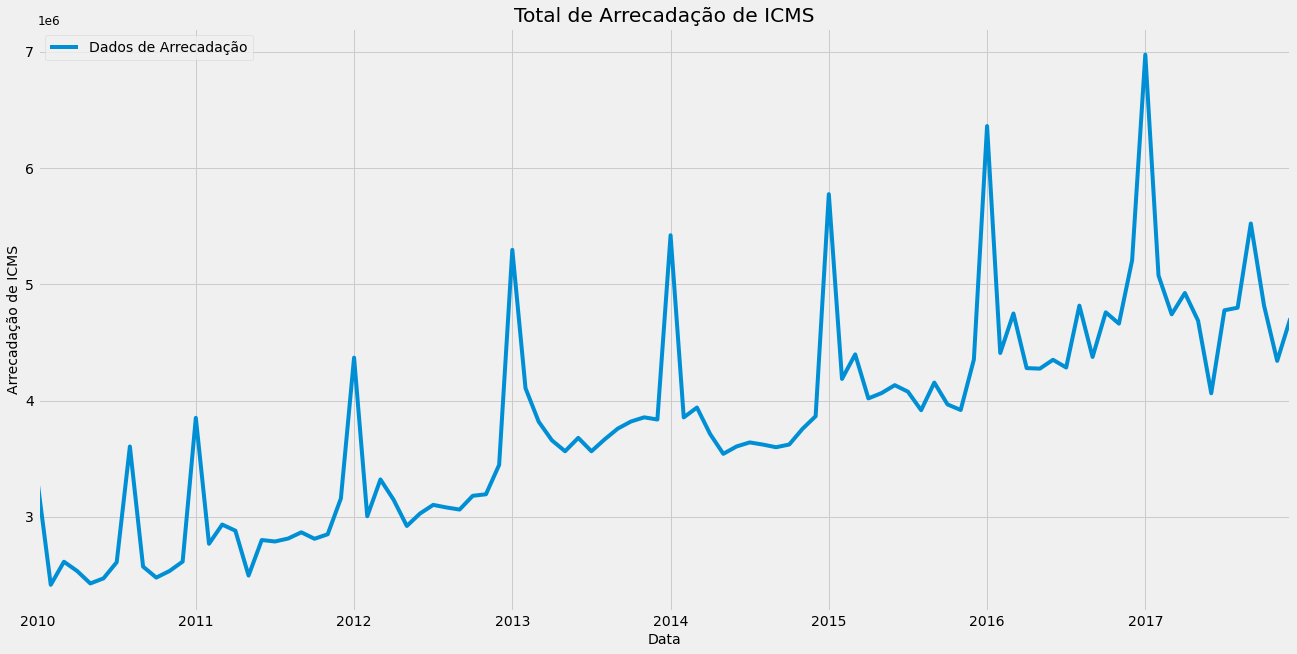

In [7]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

Agora, vamos decompor uma das séries para avaliar seus componentes.

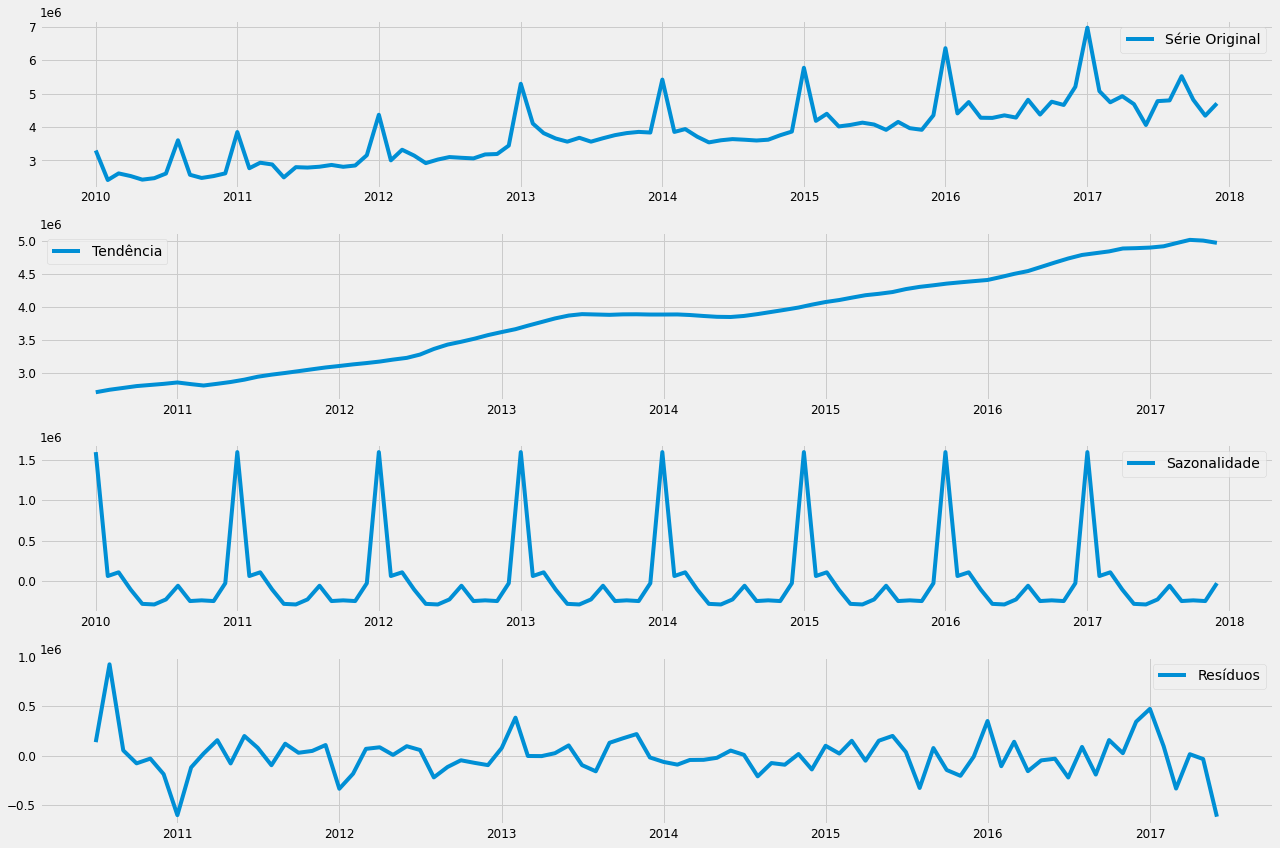

In [8]:
# Decomposição da série temporal de venda média de produtos de tecnologia
decomposition = seasonal_decompose(target, period = 12)
rcParams['figure.figsize'] = 18, 12

# Componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot
plt.subplot(411)
plt.plot(target, label = 'Série Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Tendência')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Sazonalidade')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Resíduos')
plt.legend(loc = 'best')
plt.tight_layout()

Vamos testar a estacionaridade.

In [9]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):
    
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (20, 6))
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

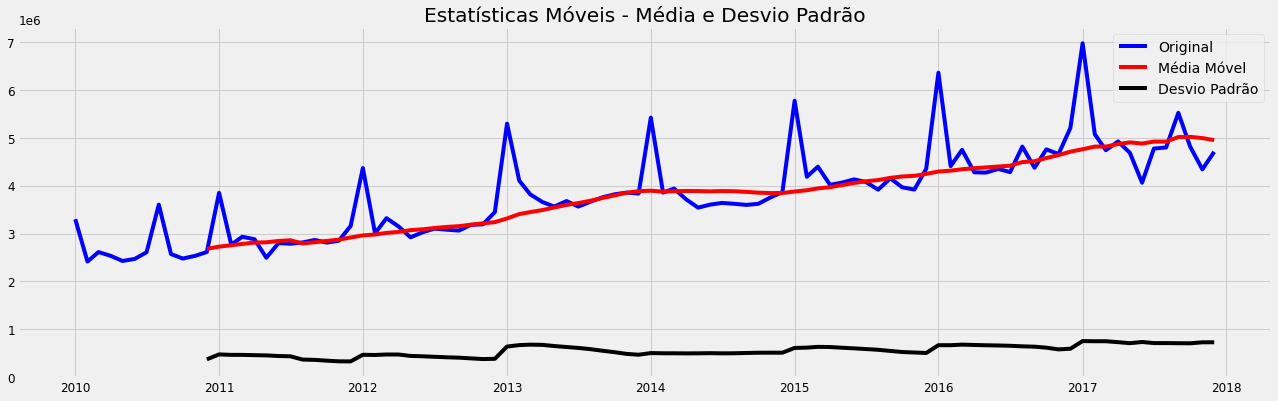


Resultado do Teste Dickey-Fuller:

Estatística do Teste            -3.891400
Valor-p                          0.002099
Número de Lags Consideradas      0.000000
Número de Observações Usadas    95.000000
Valor Crítico (1%)              -3.501137
Valor Crítico (5%)              -2.892480
Valor Crítico (10%)             -2.583275
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [10]:
# Verifica se a série é estacionária
testa_estacionaridade(target)

In [11]:
X = pd.DataFrame(target)

In [12]:
type(X)

pandas.core.frame.DataFrame

In [13]:
# Os primeiros 72 registros da série serão usados como dados de treino
X[:-24]

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702
...,...
2015-08-01,3916651
2015-09-01,4154162
2015-10-01,3966277


In [14]:
# Os últimos 24 registros da série serão usados como dados de teste
X[-24:]

,Arrecadacao
Data,
2016-01-01,6360023
2016-02-01,4408531
2016-03-01,4748431
2016-04-01,4278694
2016-05-01,4273985
2016-06-01,4350053
2016-07-01,4283739
2016-08-01,4816248
2016-09-01,4374269


In [15]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = X[:-24]
testset = X[-24:]

In [16]:
len(trainset)

72

In [17]:
trainset

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702
...,...
2015-08-01,3916651
2015-09-01,4154162
2015-10-01,3966277


In [18]:
# Função
def plot_forecast(predictor, test_data):
    for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
        to_pandas(test_entry).plot(linewidth = 2)
        forecast.plot(color = 'g', prediction_intervals = [50.0, 90.0])
    plt.grid(which = 'both')

**Preparando o Dataset para o GluonTS**

O GluonTS não requer um formato específico para um conjunto de dados. Os únicos requisitos são dados iteráveis e ter um campo "target" e "start", onde start representa o ponto inicial do índice da série (que é a data) e target o valor final da série. Só isso.

Aqui estamos usando `gluonts.dataset.common.ListDataset`. Passamos **start** como `pandas.index` e **target** como um conjunto iterável de valores do nosso dataframe pandas, coluna sales.

In [19]:
# Dataset de treino para o GluonTS
training_data = ListDataset([{"start": trainset.index[0], 
                              "target": trainset.Arrecadacao[: "2015-12-01"]}], 
                            freq = "M")

In [20]:
# Dataset de teste para o GluonTS
test_data = ListDataset([{"start": testset.index[0], 
                           "target": testset.Arrecadacao[:"2017-12-01"]}], 
                        freq = "M")

In [21]:
#training_data.list_data

In [22]:
#test_data.list_data

**Criando o Modelo:**

Um objeto estimador representa a rede e contém um treinador, que inclui tamanho do lote, inicializador, contexto, taxa de aprendizado e outros hiperparâmetros específicos do treinamento. 

O objeto estimador também inclui a frequência do registro de data e hora, o comprimento da previsão para expressar quantas etapas queremos prever e parâmetros estruturais, como o número de camadas. 

O estimador também inclui crucialmente um método de "treino". O método treino é usado para ajustar um modelo a um determinado conjunto de dados e criando assim um objeto preditivo, que pode ser usado para prever valores.

Nos exemplos a seguir, criamos um estimador DeepAR. Para mais informações sobre o DeepAR, consulte o paper (https://arxiv.org/abs/1704.04110) com base no qual o modelo está sendo desenvolvido.

In [23]:
#print("Number GPU's: " + str(mx.context.num_gpus()))

In [24]:
!C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi

Sun Aug 23 13:44:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 425.31       Driver Version: 425.31       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GT 640M LE WDDM  | 00000000:01:00.0 N/A |                  N/A |
| N/A   41C    P0    N/A /  N/A |     39MiB /  1024MiB |     N/A      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [25]:
# Criação do modelo
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
#modelo_gluonts = DeepAREstimator(freq = "M", 
#                                 prediction_length = 30, 
#                                 distr_output = NegativeBinomialOutput(),
#                                 num_layers = 50,
#                                 trainer = Trainer(ctx = "gpu(0)",
#                                                   learning_rate = 1e-3, 
#                                                   epochs = 150,
#                                                   num_batches_per_epoch = 50,
#                                                   batch_size = 32))

In [26]:
# Criação do modelo
# https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html
modelo_gluonts = DeepAREstimator(freq = "M", 
                                 prediction_length = 24, 
#                                 distr_output = NegativeBinomialOutput(),
                                 num_layers = 3,
                                 trainer = Trainer(ctx = "gpu(0)",
                                                   learning_rate = 1e-3, 
                                                   epochs = 150,
                                                   num_batches_per_epoch = 50,
                                                   batch_size = 32))

In [27]:
# Agora fazemos o treinamento
start = time()

modelo_gluonts_predictor = modelo_gluonts.train(training_data = training_data)

print ('\nTempo gasto: %s segundos' % str(time() - start))

100%|███████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.80it/s, epoch=57/150, avg_epoch_loss=12.1]


100%|██████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.79it/s, epoch=115/150, avg_epoch_loss=11.8]


100%|██████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.78it/s, epoch=150/150, avg_epoch_loss=11.5]



Tempo gasto: 1962.154051065445 segundos


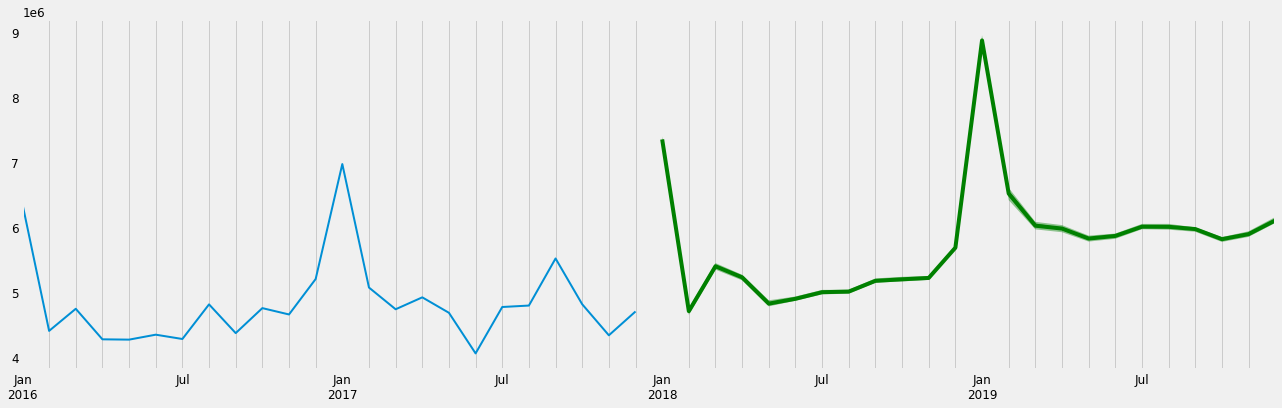

In [29]:
# Vamos plotar o forecast
# Plot
plt.figure(figsize = (20, 6))
plot_forecast(predictor = modelo_gluonts_predictor, test_data = test_data)

O forecast parece acompanhar o padrão da série. Vamos avaliar o modelo.

In [30]:
# Previsões com os dados de teste
forecast_it, ts_it = make_evaluation_predictions(dataset = test_data, 
                                                 predictor = modelo_gluonts_predictor, 
                                                 num_samples = 12)

In [31]:
# Extrai as métricas 
metricas_agregadas, metricas_item = Evaluator()(ts_it, forecast_it, num_series = len(test_data))

Running evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


In [32]:
# Visualiza as métricas
metricas_agregadas

{'MSE': 23759099177642.668,
 'abs_error': 115945904.0,
 'abs_target_sum': 115945904.0,
 'abs_target_mean': 4831079.333333333,
 'seasonal_error': nan,
 'MASE': nan,
 'MAPE': 1.0,
 'sMAPE': 2.0,
 'OWA': nan,
 'MSIS': nan,
 'QuantileLoss[0.1]': 23189181.200000003,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.2]': 46378362.400000006,
 'Coverage[0.2]': 0.0,
 'QuantileLoss[0.3]': 69567543.6,
 'Coverage[0.3]': 0.0,
 'QuantileLoss[0.4]': 92756724.80000001,
 'Coverage[0.4]': 0.0,
 'QuantileLoss[0.5]': 115945906.0,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.6]': 139135087.2,
 'Coverage[0.6]': 0.0,
 'QuantileLoss[0.7]': 162324268.39999998,
 'Coverage[0.7]': 0.0,
 'QuantileLoss[0.8]': 185513449.60000002,
 'Coverage[0.8]': 0.0,
 'QuantileLoss[0.9]': 208702630.8,
 'Coverage[0.9]': 0.0,
 'RMSE': 4874330.638933172,
 'NRMSE': 1.008952721041324,
 'ND': 1.0,
 'wQuantileLoss[0.1]': 0.20000000344988472,
 'wQuantileLoss[0.2]': 0.40000000689976944,
 'wQuantileLoss[0.3]': 0.600000010349654,
 'wQuantileLoss[0.4]': 0.8

O RMSE foi bastante alto. Nem mesmo um dos modelos mais avançados da atualidade parece ser suficiente para ajustar essa série. Médias mensais não são a forma ideal de trabalhar com séries temporais, além do fato do volume de dados ser muito baixo.

Vale ressaltar que estamos sendo bem rigorosos na avaliação dos modelos.

O modelo probabilístico autoregressivo, assim como qualquer modelo de Deep Learning, mostra seu brilho quando o volume de dados é realmente alto.

Mas esse modelo DeepAR merece sua atenção. É um dos avanços recentes em Deep Learning.

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958
- Modelo 17 --> Modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC = 1251.06 e RMSE = 332666.2626
- Modelo 18 --> Modelo SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC = 1233.47 e RMSE = 336782.4202
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 15.8048 e RMSE = 1037107.0089   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 13.1198 e RMSE = 945778.1667
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 12.3914 e RMSE = 877490.6632 
- Modelo 25 --> Modelo Bidirectional LSTM - MAPE = 10.7944 e RMSE = 850832.6951
- Modelo 26 --> Modelo DeepAR - MAPE 1.0 RMSE = 4874330.6389 


Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim